In [286]:
import os
from glob import glob
from tqdm.notebook import tqdm

import torch
from torch.utils.data import DataLoader
#from torch.utils.tensorboard import SummaryWriter
from pathlib import Path
import matplotlib.pyplot as plt

import numpy as np
import monai
from monai.data import Dataset,decollate_batch
from monai.networks import nets
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.transforms import (
    LoadImaged,
    Activations,
    AddChanneld,
    AsDiscrete,
    Compose,
    ScaleIntensityd,
    ToTensord,
    RandCropByPosNegLabeld,
    RandAffined,
    RandFlipd,
    Orientationd,
    RandGibbsNoised,
    RandGaussianSmoothd,
)


In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

print(device)

cuda:0


In [5]:
torch.cuda.empty_cache()

In [3]:
train_brain_path='...'
valid_brain_path = '...'
train_mask_path='...'
valid_mask_path='...'

train_brain_path=Path(train_brain_path)
valid_brain_path = Path(valid_brain_path)
train_mask_path = Path(train_mask_path)
valid_mask_path = Path(valid_mask_path)


In [4]:
train_brain = sorted(glob(os.path.join(train_brain_path, "*.hdr")))
valid_brain = sorted(glob(os.path.join(valid_brain_path, "*.hdr")))

train_mask = sorted(glob(os.path.join(train_mask_path, "*.hdr")))
valid_mask = sorted(glob(os.path.join(valid_mask_path, "*.hdr")))

In [10]:
train_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_brain, train_mask)
]

valid_dicts=[
    {"image": i_name, "label": l_name}
    for i_name, l_name in zip(valid_brain, valid_mask)
]

In [409]:
# define transforms for image and segmentation
train_imtrans = Compose(
    [  
        LoadImaged(keys=('image', 'label')),
        AddChanneld(keys=('image','label')),
        Orientationd(keys=('image','label'), axcodes=('ARI')),
        ScaleIntensityd(keys='image'),
        RandFlipd(keys=('image','label'),prob=0.5,spatial_axis=1),
        RandCropByPosNegLabeld(
            keys=("image", "label"),
            label_key="label",
            spatial_size=(128,128,64),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        RandAffined(keys=('image','label'),prob=0.2, rotate_range=(np.pi*0.05,np.pi*0.05,np.pi*0.05),mode=('bilinear','nearest'),padding_mode='border'),
        RandGibbsNoised(keys=('image'), prob=0.2, alpha=(0.0, 1.0)),
        RandGaussianSmoothd(keys=('image'),sigma_x=(0.25, 1.5), sigma_y=(0.25, 1.5), sigma_z=(0.25, 1.5), approx='erf', prob=0.2),
        ToTensord(keys=('image','label')),
    ]
)

val_imtrans = Compose(
    [
        LoadImaged(keys=('image', 'label')),
        AddChanneld(keys=('image','label')),
        Orientationd(keys=('image','label'), axcodes=('ARI')),
        ScaleIntensityd(keys='image'),
        ToTensord(keys=('image','label')),
    ]
)

torch.Size([1, 1, 128, 128, 64])


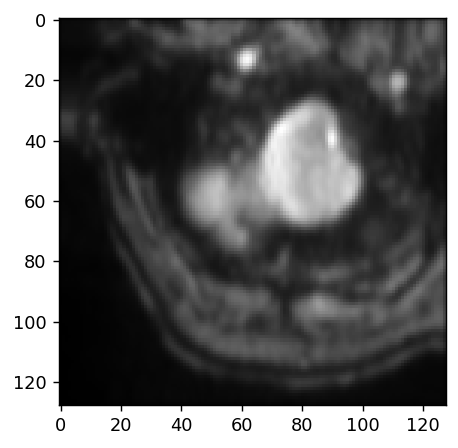

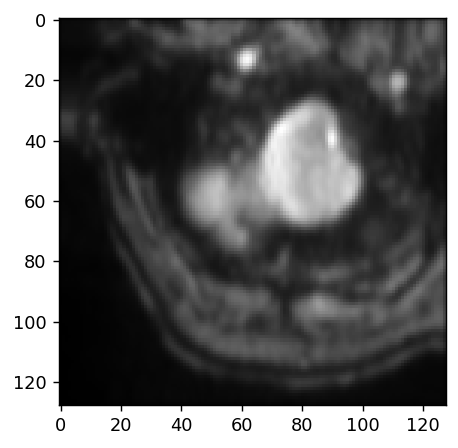

torch.float32


<Figure size 768x512 with 0 Axes>

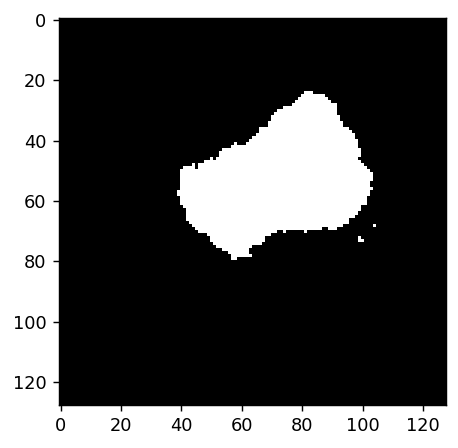

In [411]:
check_ds = Dataset(data=train_dicts,transform=train_imtrans)
check_loader = DataLoader(check_ds, batch_size=1, num_workers=0, pin_memory=torch.cuda.is_available())
im = monai.utils.misc.first(check_loader)
img=im[0]['image']
mask=im[0]['label']
print(img.shape)
plt.figure(dpi=128)
plt.imshow(img[0,0,:,:,50],cmap='gray')
plt.show()
plt.figure(dpi=128)
plt.imshow(img[0,0,:,:,50],cmap='gray')
plt.show()
plt.figure(dpi=128)
plt.figure(dpi=128)
plt.imshow(mask[0,0,:,:,50],cmap='gray')
print(mask.dtype)

torch.Size([4, 1, 256, 192, 176])


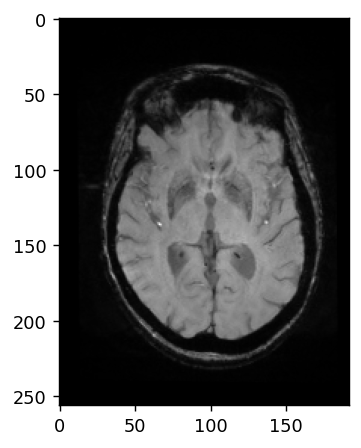

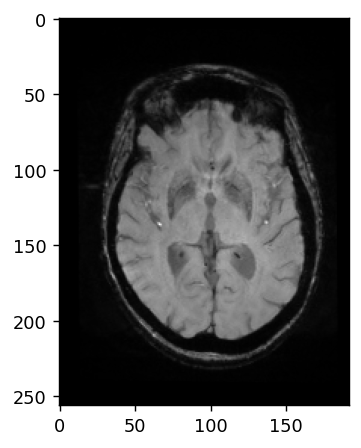

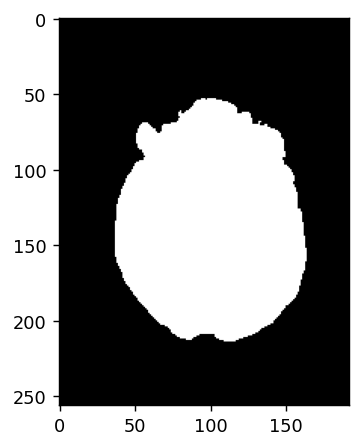

In [412]:
check_ds = Dataset(data=valid_dicts,transform=val_imtrans)
check_loader = DataLoader(check_ds, batch_size=4, num_workers=0, pin_memory=torch.cuda.is_available())
im = monai.utils.misc.first(check_loader)
img=im['image']
mask=im['label']
print(img.shape)
plt.figure(dpi=128)
plt.imshow(img[1,0,:,:,86],cmap='gray')
plt.show()
plt.figure(dpi=128)
plt.imshow(img[1,0,:,:,86],cmap='gray')
plt.show()
plt.figure(dpi=128)
plt.imshow(mask[1,0,:,:,86],cmap='gray')

In [21]:
train_ds = Dataset(data=train_dicts, transform=train_imtrans)
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=0, pin_memory=torch.cuda.is_available())

val_ds = Dataset(data=valid_dicts, transform=val_imtrans)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=0, pin_memory=torch.cuda.is_available())

In [ ]:
# create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = nets.BasicUNet(
    in_channels=1,
    out_channels=1,
    dimensions=3,
    features=(16,32,64,128,256,32),
    ).to(device)
loss_function = monai.losses.DiceLoss(sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)

dice_metric = DiceMetric(include_background=True, reduction="mean",get_not_nans=False)
post_trans = Compose(
    [Activations(sigmoid=True), AsDiscrete(threshold_values=True)]
)

In [ ]:
from monai.metrics import DiceMetric

max_epochs=200
val_interval=1
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []

print('start')
for epoch in tqdm(range(max_epochs)):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in tqdm(train_loader):
        step += 1
        inputs, labels = batch_data[0]['image'].to(device), batch_data[0]['label'].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        outputs = [post_trans(i) for i in decollate_batch(outputs)] #activation
        epoch_loss += loss.item()

    epoch_loss /= step

    print(outputs[0].shape)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
    plt.figure(dpi=128)
    plt.subplot(1,3,1)
    plt.title('input')
    plt.imshow(inputs.cpu()[0,0,:,:,50],cmap='gray')
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.title('label')
    plt.imshow(labels.cpu()[0,0,:,:,50],cmap='gray')
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.title('pred')
    plt.imshow(outputs[0].cpu().detach().numpy()[0,:,:,50],cmap='gray')
    plt.axis('off')
    plt.show()

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            metric_sum = 0.0
            metric_count= 0
            for val_data in tqdm(val_loader):
                val_inputs, val_labels = (
                    val_data['image'].to(device),
                    val_data['label'].to(device),
                )
                roi_size = (128,128,64)
                sw_batch_size = 2
                val_outputs = sliding_window_inference(
                    val_inputs, roi_size, sw_batch_size, model,overlap=0.5)
                val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                
                # compute overall mean dice
                value = dice_metric(y_pred=val_outputs, y=val_labels)
                
                metric = dice_metric.aggregate().item()
            
            metric_values.append(metric)
            plt.figure(dpi=128)
            plt.subplot(1,3,1)
            plt.title('val_input')
            plt.imshow(val_inputs.cpu()[0,0,:,:,86],cmap='gray')
            plt.axis('off')
            plt.subplot(1,3,2)
            plt.title('val_label')
            plt.imshow(val_labels.cpu()[0,0,:,:,86],cmap='gray')
            plt.axis('off')
            plt.subplot(1,3,3)
            plt.title('val_pred')
            plt.imshow(val_outputs[0].cpu()[0,:,:,86],cmap='gray')
            plt.axis('off')
            plt.show()
        
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), f".../model_{epoch}_{epoch_loss}.pth")
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )